In [ ]:
import tensorflow.keras
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.layers import Dropout
from tensorflow.keras.datasets import mnist

from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
#!pip install tqdm
from tqdm import tqdm
import random
from matplotlib import pyplot as plt

import os

In [ ]:
# loading the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
nbClasses = np.unique(y_train).shape[0]
# preprocessings
x_train = x_train.astype('float32') / 255. # 2D images
x_test = x_test.astype('float32') / 255.
xTrain = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # 1D images
xTest = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

size1 = len(xTrain[0])
size = len(x_train[0])
print(size,size1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
28 784


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_train_rgb = np.expand_dims(x_train, axis=-1)
x_train_rgb = tf.image.resize(x_train_rgb, [32,32])
x_train_rgb = np.repeat(x_train_rgb, 3, -1)
print(x_train_rgb.shape)

(60000, 32, 32, 3)


In [ ]:
y_train_rgb = y_train

In [ ]:
# resnet50 = tf.keras.applications.ResNet50(
#     weights='imagenet', include_top=False
# )
# resnet50.summary()

In [ ]:
VGGmodel = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
VGGmodel.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # we will add layers to this feature extraction part of VGG network
# m = resnet50.output
# # we start with a global average pooling
# m = GlobalAveragePooling2D()(m)
# # and add a fully-connected layer
# m = Dense(1024, activation='relu')(m)
# # finally, the softmax layer for predictions (we have nbClasses classes)
# predictions = Dense(nbClasses, activation='softmax')(m)

# # global network
# model = Model(inputs=VGGmodel.input, outputs=predictions)
# model.summary()

In [ ]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# and add a fully-connected layer
m = Dense(1024, activation='relu')(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,250,250 (58.18 MB)

 Trainable params: 15,250,250 (58.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# x_train_rgb = x_train_rgb[:500]
# y_train_rgb = y_train[:500]

In [ ]:
x_train_rgb.shape

(60000, 32, 32, 3)

In [ ]:
# training
ourCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
batch_size = 128
epochs = 8

# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train_rgb, y_train_rgb, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[ourCallback],verbose=1)

Epoch 1/8
  1/375 ━━━━━━━━━━━━━━━━━━━━ 19:26 3s/step - accuracy: 0.0703 - loss: 2.4279

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
tp_data_root = "/content/drive/My Drive/tp_pgd/"
model_weight_filename = "pgd_mnist.weights.h5"

In [ ]:
# model.save_weights(os.path.join(tp_data_root, model_weight_filename))

In [ ]:
model.load_weights(os.path.join(tp_data_root, model_weight_filename))

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def create_adversarial_pattern(input_image, input_label, model):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        # input_image = np.array(input_image)
        if (tf.is_tensor(input_image)):
          input_image = input_image.numpy()
        # input_image = input_image.reshape((1,) + input_image.shape)
        input_image = tf.convert_to_tensor(input_image)
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

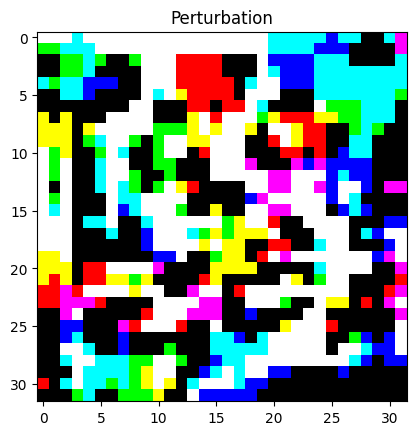

In [ ]:
perturbations = create_adversarial_pattern(x_train_rgb[0:1], y_train_rgb[0:1], model)
plt.imshow(perturbations[0])
plt.title("Perturbation")
plt.show()

In [ ]:
  def PGD_attack(model, image, label, epsilon, iter_eps, iterations):
    adv_image = image
    ncols = 4
    fig, axs = plt.subplots(nrows=math.ceil((iterations+1) / ncols), ncols=ncols, figsize = (10, 8))
    j = 0
    k = 0
    pred = model.predict(adv_image, verbose=0)
    labelx = np.argmax(pred)
    confidence = np.max(pred)
    axs[j][k].imshow(adv_image[0])
    axs[j][k].set(title=f"Model Prediction: {labelx} ({confidence*100:.2f}%)")
    axs[j][k].grid(False)
    axs[j][k].set_xticks([])
    axs[j][k].set_yticks([])
    for i in range(1, iterations + 1):
        j = i // ncols
        k = i % ncols
        perturbations = create_adversarial_pattern(adv_image, label, model)
        adv_image = adv_image + iter_eps*perturbations
        adv_image = tf.clip_by_value(adv_image, image - epsilon, image + epsilon)
        adv_image = tf.clip_by_value(adv_image, 0, 1)  # ensure valid pixel range
        pred = model.predict(adv_image, verbose=0)
        labelx = np.argmax(pred)
        confidence = np.max(pred)
        description = labelx
        # decoded =  decoder_pred(pred)
        # description,labelx, confidence = decoded[0][0]
        # print(f"Iteration: {i+1}"+"\n"+f"Epsilon: {iter_eps}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        axs[j][k].imshow(adv_image[0])
        axs[j][k].set(title=f"Iteration: {i}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        axs[j][k].grid(False)
        axs[j][k].set_xticks([])
        axs[j][k].set_yticks([])
    fig.tight_layout()
    fig.savefig(os.path.join(tp_data_root, "pgd_attack_result.png"))
    plt.show()
    return adv_image

In [ ]:
def PGD_attack_2(model, image, label, epsilon, iter_eps, iterations):
    adv_image = image
    for i in range(iterations):
        perturbations = create_adversarial_pattern(adv_image, label, model)
        adv_image = adv_image + iter_eps*perturbations
        adv_image = tf.clip_by_value(adv_image, image - epsilon, image + epsilon)
        adv_image = tf.clip_by_value(adv_image, 0, 1)  # ensure valid pixel range
        pred = model.predict(adv_image, verbose = 0)
        labelx = np.argmax(pred)
        confidence = np.max(pred)
        description = labelx
        # decoded =  decoder_pred(pred)
        # description,labelx, confidence = decoded[0][0]
        print(f"Iteration: {i+1}"+"\n"+f"Epsilon: {iter_eps}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        fig, ax = plt.subplots()
        ax.imshow(adv_image[0])
        ax.set(title=f"Iteration: {i+1}"+"\n"+f"Predicted: {labelx} ({confidence*100:.2f}%)")
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()
    return adv_image



In [ ]:
def plot_prediction(model, input_img):
    pred = model.predict(input_img, verbose = 0)
    labelx = np.argmax(pred)
    confidence = np.max(pred)
    description = labelx
    fig, ax = plt.subplots()
    ax.imshow(input_img[0])
    ax.set(title=f"Prediction: {labelx} ({confidence*100:.2f}%)")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [ ]:
import math

iterations = 7
epsilon = 0.25
iter_eps = 0.08
# savePath='/content/drive/My Drive/saved_img/'
# iter_num = math.ceil(x_train_rgb.shape[0] / batch_size)

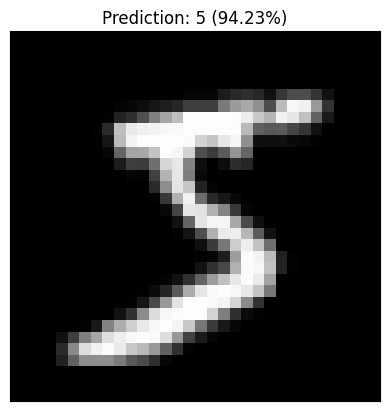

In [ ]:
plot_prediction(model, x_train_rgb[0:1])

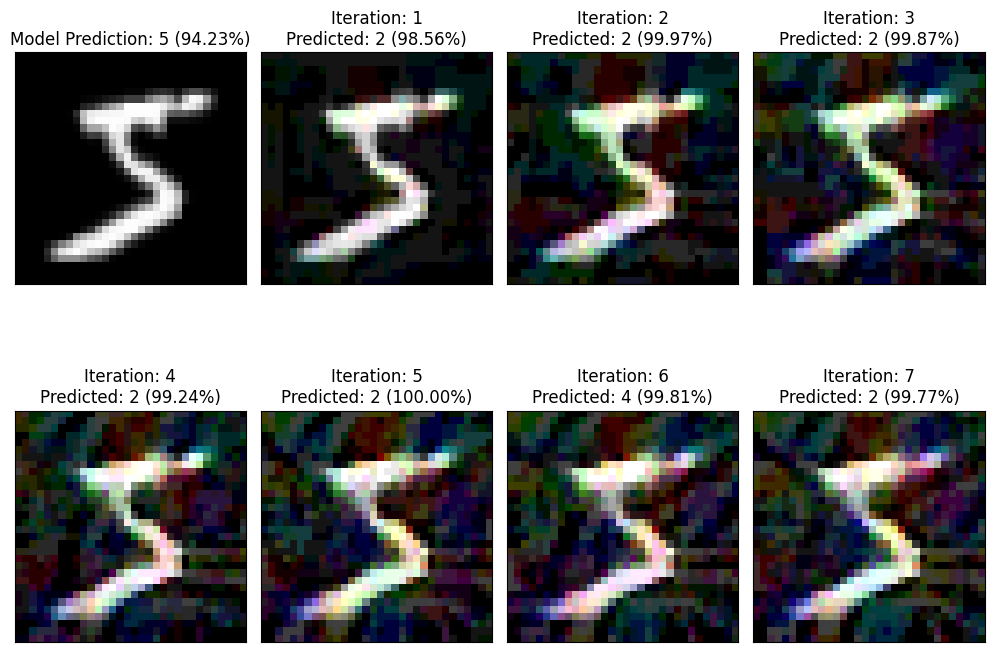

In [ ]:
adv_images = PGD_attack(model, x_train_rgb[0:1], y_train_rgb[0:1], epsilon, iter_eps, iterations)

Iteration: 1
Epsilon: 0.06
Predicted: 2 (96.68%)


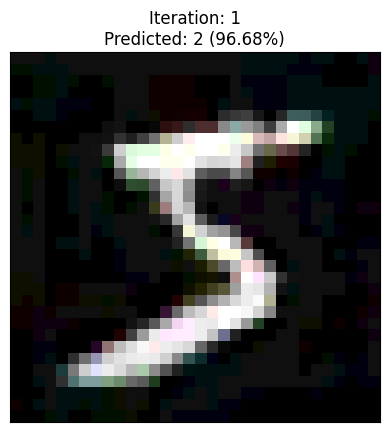

Iteration: 2
Epsilon: 0.06
Predicted: 2 (99.98%)


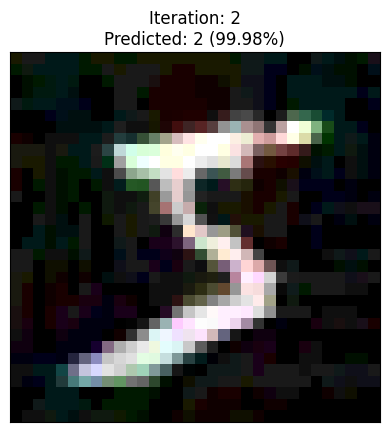

Iteration: 3
Epsilon: 0.06
Predicted: 2 (99.93%)


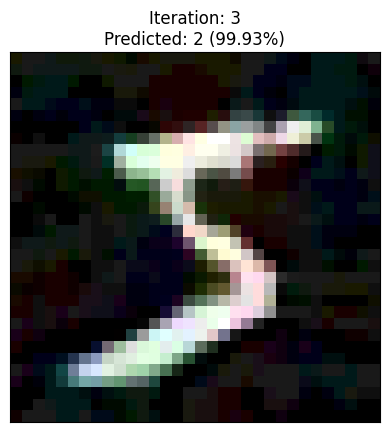

Iteration: 4
Epsilon: 0.06
Predicted: 2 (99.88%)


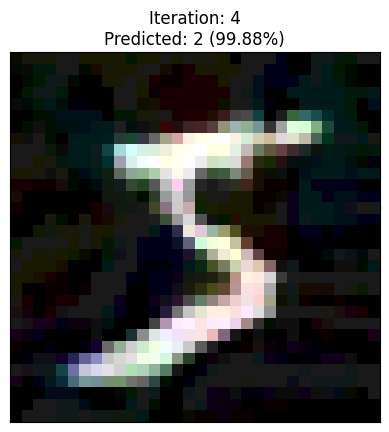

Iteration: 5
Epsilon: 0.06
Predicted: 2 (99.70%)


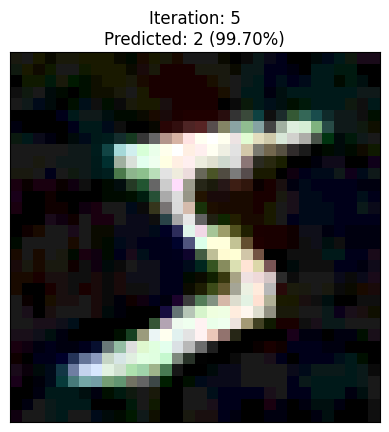

In [ ]:
adv_images_2 = PGD_attack_2(model, x_train_rgb[0:1], y_train_rgb[0:1], epsilon, iter_eps, iterations)

# References

\[1] Madry, Aleksander. "Towards deep learning models resistant to adversarial attacks." arXiv preprint arXiv:1706.06083 (2017).

\[2] Oscar Knagg, Towards Data Science, https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3